In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/MSBA/BA890/data

Mounted at /gdrive
/gdrive/My Drive/MSBA/BA890/data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
! ls

ingr_map.pkl		interactions_validation.csv  RAW_interactions.csv
interactions_test.csv	PP_recipes.csv		     RAW_recipes.csv
interactions_train.csv	PP_users.csv


In [4]:
df_recipes = pd.read_csv('RAW_recipes.csv')
df_interact = pd.read_csv('RAW_interactions.csv')
train_interact = pd.read_csv('interactions_train.csv')

In [5]:
df_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [6]:
df_interact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


In [7]:
train_interact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    698901 non-null  int64  
 1   recipe_id  698901 non-null  int64  
 2   date       698901 non-null  object 
 3   rating     698901 non-null  float64
 4   u          698901 non-null  int64  
 5   i          698901 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 32.0+ MB


In [8]:
# join recipes on interactions to see which recipes are most popular
df = pd.merge(train_interact, df_recipes[['name','id']], left_on='recipe_id', right_on='id')
del df['id']

In [9]:
df.head()

,user_id,recipe_id,date,rating,u,i,name
0,2046,4684,2000-02-25,5.0,22095,44367,flank steak with lime chipotle sauce
1,12882,4684,2002-03-13,5.0,10399,44367,flank steak with lime chipotle sauce
2,37758,4684,2002-06-17,5.0,4954,44367,flank steak with lime chipotle sauce
3,37636,4684,2003-05-08,5.0,831,44367,flank steak with lime chipotle sauce
4,54697,4684,2003-06-30,5.0,1147,44367,flank steak with lime chipotle sauce


# Non-personalized Recommendations

This method will recommend recipes based on combiniations of recipes reviewers have cooked/reviewed over time. For example, if many reviewers cooked and reviewed a chicken pot pie recipe and an omelette recipe in the past, the omelette recipe may be recommended the next time someone views the chicken pot pie recipe.

In [10]:
df.shape

(698901, 7)

In [11]:
# had to drop observations due to RAM limitations
df2 = df.copy().sample(100000)
df2.shape

(100000, 7)

In [12]:
from itertools import permutations

# Create the function to find all permutations
def find_recipe_pairs(x):
  pairs = pd.DataFrame(list(permutations(x.values, 2)),
                       columns=['recipe_a', 'recipe_b'])
  return pairs

# Apply the function to the title column and reset the index
recipe_combinations = df2.groupby('user_id')['recipe_id'].apply(
  find_recipe_pairs).reset_index(drop=True)

print(recipe_combinations)

        recipe_a recipe_b
0          10332    11914
1          10332    46877
2          10332    76417
3          10332    13813
4          10332    24415
...          ...      ...
8004307    34110    86125
8004308    86125   299148
8004309    86125    34110
8004310   152337   296559
8004311   296559   152337

[8004312 rows x 2 columns]


In [13]:
combination_counts = recipe_combinations.groupby(['recipe_a', 'recipe_b']).size()

# Convert the results to a DataFrame and reset the index
combination_counts_df = combination_counts.to_frame(name='size').reset_index()
combination_counts_df.sort_values('size', ascending=False, inplace=True)
combination_counts_df.head()

,recipe_a,recipe_b,size
1328980,67256,73825,6
1033148,54257,33919,6
1456703,73825,67256,6
108490,10744,68955,6
1360609,68955,10744,6


Lets see what happens when we want to recommend the most reviewed recipe (best banana bread, id = 2886)

In [14]:
banana_bread = combination_counts_df[combination_counts_df['recipe_a'] == 2886]
banana_bread = pd.merge(banana_bread, df_recipes[['id','name']], how='inner', left_on='recipe_b', right_on = 'id')
banana_bread = banana_bread.rename(columns={'name':'recommendation'})
del banana_bread['id']
banana_bread.head(10)

,recipe_a,recipe_b,size,recommendation
0,2886,137725,2,healthy no bake cookies
1,2886,8579,2,beef roast
2,2886,54257,2,yes virginia there is a great meatloaf
3,2886,29679,2,reeses squares 5 ingredients no bake reese s
4,2886,36984,2,the best browned beef stew ever
5,2886,57633,1,chocolate pecan pie cake
6,2886,28148,1,oven fried chicken chimichangas
7,2886,40879,1,taco ritos
8,2886,40857,1,crock pot teriyaki steak
9,2886,39915,1,oh so good chicken


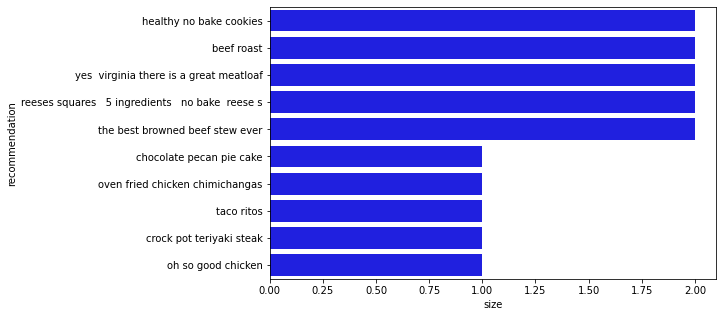

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(data=banana_bread.head(10), x='size', y='recommendation', color = 'blue')

Based on this non-personalized recommendation system, those who enjoyed making the banana bread may chose to cook: 
* crispy ginger beef
* crockpot chicken with black beans and cream cheese
* japanese mum's chicken
* (another) banana bread
* most incedible no fail pie crust

In [16]:
combination_counts_df.tail(15)

,recipe_a,recipe_b,size
2668187,131373,50600,1
2668174,131372,428761,1
2668186,131373,41415,1
2668185,131373,41384,1
2668184,131373,39318,1
2668183,131373,39048,1
2668182,131373,38990,1
2668181,131373,38753,1
2668180,131373,32204,1
2668179,131373,18308,1


With that said, this method may not work for recipes with very limited combinitations (or none). It may present a 'cold start' problem for recipes that are new and have not been reviewed by other users.

# Content-Based Recommendations

Content-based recommendations use the similarities of the recipes to provide recommendations. For example, if a user liked cooking an apple pie, they might also like blueberry pies on the account that they are both fruit-based pies. Another example could be that if someone liked cooking an italian dish like spaghetti bolognese, they might also like cooking lasagna.

The trouble with our current data is that there is no straightforward feature that could act as a comparison (e.g. *cuisine*). Therefore, we might need to do some NLP feature engineering.

Let's first try by using the name of the recipes.

In [17]:
# use sample of 10000 to minimize memory requirements
df_recipes2 = df_recipes.sample(5000, random_state=1)
df_recipes2.reset_index(drop=True, inplace=True)

### Using Count Vectorizer and Jaccard

In [18]:
# use Count Vectorizer to get count words in list of names
from sklearn.feature_extraction.text import CountVectorizer
V = CountVectorizer(stop_words = 'english') # initialize vectorizer with common stopwords

X = V.fit_transform(df_recipes2.name)
# V.get_feature_names()
# vectorizer.get_stop_words()

In [19]:
count_vect_df = pd.DataFrame(X.todense(), columns=V.get_feature_names())
count_vect_df

,007,10,101,11,12,123,140,15,1968,1998,1pt,1st,2008,21,24,2bleu,30,35,36,3pts,4th,4u,50,52,57,5fix,7points,a1,aarsi,abm,abricots,absolutely,acadia,acapulco,according,achiote,acorn,adams,adaptation,adapted,...,yellow,yemani,yemen,yemeni,yemista,yes,yigandes,yo,yoghurt,yogurt,york,yosemite,yucatan,yucca,yule,yum,yummiest,yummy,za,zabaglione,zalm,zard,zealand,zest,zesty,zinger,zings,zingy,zippy,ziti,zitronenvinaigrette,zo,zrigschntzlets,zucchini,zuppa,zurbian,zurich,zurie,zwina,zwt
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# set name of recipe as index 
count_vect_df = count_vect_df.set_index(df_recipes2.name)

In [21]:
from scipy.spatial.distance import pdist, squareform

# calculating jaccard distances for each recipe
jaccard_distances = pdist(count_vect_df.values, metric='jaccard')
print(jaccard_distances)

[1. 1. 1. ... 1. 1. 1.]


In [22]:
# Convert the distances to a square matrix
jaccard_similarity_array = 1 - squareform(jaccard_distances)

# Wrap the array in a pandas DataFrame
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_array, index=count_vect_df.index, columns=count_vect_df.index)

In [23]:
jaccard_similarity_df.sample(3, random_state=1)

name,tomato stuffed roasted red peppers,almond cake from albufeira portugal,bean burritos simple for camping,potato gorgonzola gratin,orange glazed barbecued chicken,ghost pepper fresh salsa,musalaydaar baingun,giada de laurentiis fettuccine alfredo,zesty cajun skirt steak,penne with rustic lentil sauce,lemon parmigiano artichoke casserole,overnight cinnamon swirl cranberry french toast,southwest rub,shallow fry buttermilk pecan chicken,awesome bbq pulled pork no smoker or barbecue needed,raspberry poke cake,zippy steak,chutney glazed chicken,taco chicken wings,rachael ray s tilapia with tomatillo sauce,herbed balsamic chicken breasts,twice baked potatoes,swiss cheesy cauliflower,pressure cooker golden mushroom beef stew,cherry filled crescent rolls,corned beef dinner in the crock pot,lennie and donna s souper rice curry,deep fried shrimp cakes taud man goong,chocolate gingerbread cookies,spanish spice rubbed rib eye with sherry vinegar steak sauce,emeril s con queso,artichoke and crab dip,pumpkin curry,stuffed chicken breasts with brie basil and sun dried tomato,crab tampico,rosemary garlic seasoning,strawberry tofu mousse,amish brown sugar pie,broccoli with lemon almond butter,buster brown cake with rich vanilla icing,...,cornmeal pound cake,buffalo chicken fritos pie,border paella,black forest chocolate mousse shots,beer bacon potato soup aka man soup,mushroom bread pudding,daddy s barley casserole,aloha salmon,melt and mix chocolate chunk mud cake,spicy ranch chicken wings,cream of chanterelle soup,apricot pork medallions,tequila lime marinade,lancaster county pa tapioca recipe,marinated beef tenderloin sandwiches,british yogurt cheese,sweet potato black bean salad,moscow bobsled shot drink you decide,vegetable breakfast pizza,cruzan cherry pop,easy greek style string green beans,awesome spinach quiche,lazy stuffed cabbage casserole,yum yum bars,butter tart muffins,roast butternut squash with lemon and mustard,homemade eggnog,grandma s city chicken,ravioli with prosciutto roma tomato and sage,pollis house dressing,cinnamon date cake,power cookies,chili roasted salmon,garlic and herb bread france,peach and papaya salsa,gourmet magazine s asian cucumber ribbon salad,macadamia toffee chip cookies,peel and eat shrimp with spicy cocktail sauce,tapenade in 5 minutes,easy pan con tomato
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nana s chicken seafood gumbo courtesy the neelys,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.125,0.125,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
apricot and orange cream cream aux abricots et oranges,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
easy healthy weeknight tuna tomato skillet,0.1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714


Looking at sample of the recipes, it seems that we can find similarities already. 

'**nana's chicken seafood gumbo courtesy the neelys**' is similar to '**orange glazed barbecued chicken**' likely due to presence of the word 'chicken'

Let's see what else might be recommended if we cooked orange glazed barbecue chicken:

In [24]:
jaccard_similarity_df['orange glazed barbecued chicken'].sort_values(ascending=False).to_frame().head(10)

,orange glazed barbecued chicken
name,
orange glazed barbecued chicken,1.000000
orange glazed breaded chicken,0.600000
simply yummy orange glazed chicken wings,0.428571
marinated barbecued chicken,0.400000
orange piccata chicken,0.400000
chutney glazed chicken,0.400000
soy glazed chicken thighs,0.333333
junior league barbecued chicken,0.333333
chinese zesty orange chicken,0.333333


For **orange glazed barbecued chicken**, this content-based recommender using the names of the recipes would recommend the following top 3 options:
1. orange glazed breaded chicken
2. simply yummy orange glazed chicken wings
3. marinated barbecued chicken

### Using TF-IDF and Cosine similarity

Now let's try using a different vectorizer and similarity metric. 

Without getting into the math, let's breakdown the main differenc between the vectorizers: unlike count vectorizer, TF-IDF takes into account how frequent the word appears in the bag of words. For example, if the word 'best' appears often in the name of the recipe, less weight is given to the vector score as opposed to somethine less frequent like 'glazed')

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
V = TfidfVectorizer(stop_words = 'english') # initialize vectorizer with common stopwords

X = V.fit_transform(df_recipes2.name)

In [26]:
count_vect_df = pd.DataFrame(X.todense(), columns=V.get_feature_names())
count_vect_df

,007,10,101,11,12,123,140,15,1968,1998,1pt,1st,2008,21,24,2bleu,30,35,36,3pts,4th,4u,50,52,57,5fix,7points,a1,aarsi,abm,abricots,absolutely,acadia,acapulco,according,achiote,acorn,adams,adaptation,adapted,...,yellow,yemani,yemen,yemeni,yemista,yes,yigandes,yo,yoghurt,yogurt,york,yosemite,yucatan,yucca,yule,yum,yummiest,yummy,za,zabaglione,zalm,zard,zealand,zest,zesty,zinger,zings,zingy,zippy,ziti,zitronenvinaigrette,zo,zrigschntzlets,zucchini,zuppa,zurbian,zurich,zurie,zwina,zwt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# set name of recipe as index 
count_vect_df = count_vect_df.set_index(df_recipes2.name)

In [28]:
from scipy.spatial.distance import pdist, squareform

# calculating jaccard distances for each recipe
cosine_distances = pdist(count_vect_df.values, metric='cosine')
print(cosine_distances)

[1. 1. 1. ... 1. 1. 1.]


In [29]:
# Convert the distances to a square matrix
cosine_similarity_array = 1 - squareform(cosine_distances)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=count_vect_df.index, columns=count_vect_df.index)

In [30]:
cosine_similarity_df.sample(3, random_state=1)

name,tomato stuffed roasted red peppers,almond cake from albufeira portugal,bean burritos simple for camping,potato gorgonzola gratin,orange glazed barbecued chicken,ghost pepper fresh salsa,musalaydaar baingun,giada de laurentiis fettuccine alfredo,zesty cajun skirt steak,penne with rustic lentil sauce,lemon parmigiano artichoke casserole,overnight cinnamon swirl cranberry french toast,southwest rub,shallow fry buttermilk pecan chicken,awesome bbq pulled pork no smoker or barbecue needed,raspberry poke cake,zippy steak,chutney glazed chicken,taco chicken wings,rachael ray s tilapia with tomatillo sauce,herbed balsamic chicken breasts,twice baked potatoes,swiss cheesy cauliflower,pressure cooker golden mushroom beef stew,cherry filled crescent rolls,corned beef dinner in the crock pot,lennie and donna s souper rice curry,deep fried shrimp cakes taud man goong,chocolate gingerbread cookies,spanish spice rubbed rib eye with sherry vinegar steak sauce,emeril s con queso,artichoke and crab dip,pumpkin curry,stuffed chicken breasts with brie basil and sun dried tomato,crab tampico,rosemary garlic seasoning,strawberry tofu mousse,amish brown sugar pie,broccoli with lemon almond butter,buster brown cake with rich vanilla icing,...,cornmeal pound cake,buffalo chicken fritos pie,border paella,black forest chocolate mousse shots,beer bacon potato soup aka man soup,mushroom bread pudding,daddy s barley casserole,aloha salmon,melt and mix chocolate chunk mud cake,spicy ranch chicken wings,cream of chanterelle soup,apricot pork medallions,tequila lime marinade,lancaster county pa tapioca recipe,marinated beef tenderloin sandwiches,british yogurt cheese,sweet potato black bean salad,moscow bobsled shot drink you decide,vegetable breakfast pizza,cruzan cherry pop,easy greek style string green beans,awesome spinach quiche,lazy stuffed cabbage casserole,yum yum bars,butter tart muffins,roast butternut squash with lemon and mustard,homemade eggnog,grandma s city chicken,ravioli with prosciutto roma tomato and sage,pollis house dressing,cinnamon date cake,power cookies,chili roasted salmon,garlic and herb bread france,peach and papaya salsa,gourmet magazine s asian cucumber ribbon salad,macadamia toffee chip cookies,peel and eat shrimp with spicy cocktail sauce,tapenade in 5 minutes,easy pan con tomato
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nana s chicken seafood gumbo courtesy the neelys,0.000000,0.0,0.0,0.0,0.052604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040654,0.0,0.0,0.0,0.059142,0.060595,0.0,0.050469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035245,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.046626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052226,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.053814,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
apricot and orange cream cream aux abricots et oranges,0.000000,0.0,0.0,0.0,0.123260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.181046,0.18701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
easy healthy weeknight tuna tomato skillet,0.133868,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093450,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091545,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.09944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318996


As seen here, **nana's chicken seafood gumbo** is less similar to the **orange glazed barbecued chicken**, likely because the word 'chicken', which is where the similarity lies, appears many times in the bag of words (recipe names).

In [ ]:
cosine_similarity_df['orange glazed barbecued chicken'].sort_values(ascending=False).to_frame().head(10)

With the TF-IDF vectorizer and cosine similarity, the recommendations change a little.

### Using TF-IDF on ingredients instead of name

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# nulls present in description of 97 recipes, we're dropping those recipes 
df_recipes2_no_nulls = df_recipes2.dropna(axis=0).reset_index()

# sampling again because TF-IDF with bigrams on more words will be too much on RAM
df_recipes2_no_nulls = df_recipes2_no_nulls.sample(500, random_state=1)

V = TfidfVectorizer(stop_words = 'english', ngram_range=(1,2)) # initialize vectorizer with the inclusion of bigrams this time
X = V.fit_transform(df_recipes2_no_nulls.description)

In [ ]:
count_vect_df = pd.DataFrame(X.todense(), columns=V.get_feature_names())
count_vect_df

In [ ]:
# set name of recipe as index 
count_vect_df = count_vect_df.set_index(df_recipes2_no_nulls.name)

In [ ]:
from scipy.spatial.distance import pdist, squareform

# calculating cosine distances for each recipe
cosine_distances = pdist(count_vect_df.values, metric='cosine')
print(cosine_distances)

In [ ]:
# Convert the distances to a square matrix
cosine_similarity_array = 1 - squareform(cosine_distances)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=count_vect_df.index, columns=count_vect_df.index)

In [ ]:
cosine_similarity_df.sample(3, random_state=1)

As seen here, **nana's chicken seafood gumbo** is less similar to the **orange glazed barbecued chicken**, likely because the word 'chicken', which is where the similarity lies, appears many times in the bag of words (recipe names).

In [ ]:
cosine_similarity_df['orange glazed barbecued chicken'].sort_values(ascending=False).to_frame().head(10)